In [3]:
from escnn import nn, gspaces
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
@torch.inference_mode()
def distance_torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    x = x.flatten(1); y = y.flatten(1)
    diff  = torch.linalg.vector_norm(x - y, dim=1)
    denom = torch.maximum(torch.linalg.vector_norm(x, dim=1),
                          torch.linalg.vector_norm(y, dim=1))
    denom = torch.where(denom > 0, denom, torch.ones_like(denom))
    return diff/denom
@torch.inference_mode()
def check_equivariance_batch(x_geo, model, group, num_samples=64):
    """
    Vectorized equivariance test: f(g·x) ?= g·f(x)
    Batches over rotations by stacking along the **batch** dim.
    """
    # sample elements
    thetas = np.linspace(0, 2*np.pi, num_samples, endpoint=True)
    elems  = [group.fibergroup.element(float(t)) for t in thetas]

    # stack rotated inputs along batch dimension
    xs = [x_geo.transform(g) for g in elems]  # list of GeometricTensor
    xb_tensor = torch.cat([gt.tensor for gt in xs], dim=0)          # (K*N, C, H, W)
    xb = nn.GeometricTensor(xb_tensor, x_geo.type)                 # preserve FieldType

    # single forward pass
    yb = model(xb)  # GeometricTensor, (K*N, C', H', W')

    # reference forward, then transform outputs and stack along batch
    y_ref = model(x_geo)                                            # (N, C', H', W')
    ys = [y_ref.transform(g) for g in elems]
    y_ref_b_tensor = torch.cat([gt.tensor for gt in ys], dim=0)     # (K*N, C', H', W')
    y_ref_b = nn.GeometricTensor(y_ref_b_tensor, y_ref.type)

    # per-sample relative error
    errs = distance_torch(yb.tensor, y_ref_b.tensor)                 # (K*N,)
    # average across original batch if N>1
    N = x_geo.tensor.shape[0]
    return thetas, errs.view(num_samples, N).mean(dim=1).cpu().numpy()


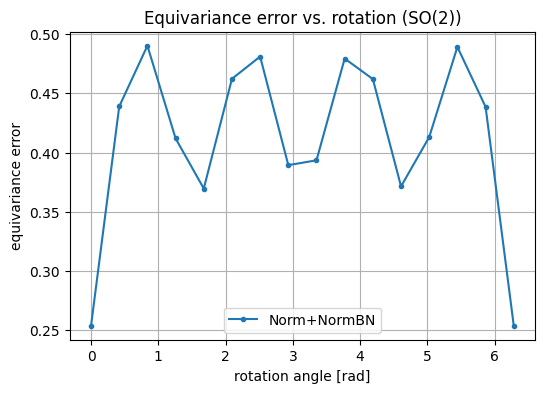

In [5]:
import torch, numpy as np, matplotlib.pyplot as plt
from escnn import gspaces, nn

# --- group & test sampler ---
r2_act = gspaces.rot2dOnR2(maximum_frequency=1)
num_samples = 16
thetas = np.linspace(0, 2*np.pi, num_samples, endpoint=True)
elements = [r2_act.fibergroup.element(theta) for theta in thetas]

g = gspaces.rot2dOnR2(N=-1)                   # SO(2)
G = g.fibergroup
ft_in = nn.FieldType(g, [g.trivial_repr])     # scalar input
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- model builders (same depth: conv -> act/norm -> bn -> conv) ---
def build_norm_normbn(C=8):
    ft = nn.FieldType(g, [g.irrep(0), g.irrep(1)]*C)      # pure nontrivial => NormBN valid
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft, 3, padding=1, bias=False),
        nn.IIDBatchNorm2d(ft, affine=True),
        nn.NormNonLinearity(ft),
        nn.R2Conv(ft, ft, 3, padding=1, bias=False),
    )

def build_gated_gnormbn(C=8):
    feats = [g.irrep(0), g.irrep(1)]*C
    gates = [g.trivial_repr]*len(feats)
    ft_full = nn.FieldType(g, gates + feats)       # gates FIRST
    ft_feat = nn.FieldType(g, feats)  # for batchnorm
    len(ft_feat)
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft_full, 3, padding=1, bias=False),
        nn.GatedNonLinearity1(ft_full, drop_gates=True),
        nn.FieldNorm(ft_feat, affine=True),
        nn.R2Conv(ft_feat, ft_feat, 3, padding=1, bias=False),
    )

def build_tensorproduct_11_to_2(C=8):
    ft1 = nn.FieldType(g, [g.irrep(1)]*C)          # uniform in
    ft2 = nn.FieldType(g, [g.irrep(2)]*C)          # valid: 1⊗1 -> 2
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft1, 3, padding=1, bias=False),
        nn.TensorProductModule(ft1, ft2, initialize=True),
        nn.FieldNorm(ft2, affine=True),
        nn.R2Conv(ft2, ft1, 3, padding=1, bias=False),  # keep width comparable
    )

def build_fourier_pointwise(C=8, L=3, N=16):
    act = nn.FourierPointwise(g, channels=C, irreps=G.bl_irreps(L), N=N)
    ft = act.out_type
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft, 3, padding=1, bias=False),
        act,
        nn.FieldNorm(ft, affine=True),
        nn.R2Conv(ft, ft, 3, padding=1, bias=False),
    )

models = {
    "Norm+NormBN":        build_norm_normbn(8),
    # "Gated+GNormBN":      build_gated_gnormbn(8),
    # "TensorProd(1x1→2)":  build_tensorproduct_11_to_2(8),
    # "FourierPointwise":   build_fourier_pointwise(8, L=0, N=16),
}

# --- run equivariance tests ---
x = torch.randn(1, 1, 128, 128)
x = ft_in(x).to(device)

plt.figure(figsize=(6,4))
for name, model in models.items():
    model = model.to(device)
    thetas_out, errors = check_equivariance_batch(x, model, group=r2_act, num_samples=num_samples)
    plt.plot(thetas_out, errors, marker="o", ms=3, label=name)
plt.xlabel("rotation angle [rad]"); plt.ylabel("equivariance error")
plt.title("Equivariance error vs. rotation (SO(2))")
plt.legend(); plt.grid(True); plt.show()


In [6]:
# new file: SO2_Nets/adaptive_fourier.py
import torch
from escnn import nn

class SamplingBranch(torch.nn.Module):
    def __init__(self, r2_act, in_type: nn.FieldType, N: int, hidden_ch: int = 16):
        super().__init__()
        self.N = N
        # small equivariant conv stack -> outputs N scalar trivial fields that we interpret as angles on S1
        self.net = nn.SequentialModule(
            nn.R2Conv(in_type, nn.FieldType(r2_act, hidden_ch * [in_type.fibergroup.trivial_repr]), kernel_size=3, padding=1, bias=False),
            nn.IIDBatchNorm2d(nn.FieldType(r2_act, hidden_ch * [in_type.fibergroup.trivial_repr])),
            nn.ReLU(inplace=True),
            nn.R2Conv(nn.FieldType(r2_act, hidden_ch * [in_type.fibergroup.trivial_repr]),
                      nn.FieldType(r2_act, self.N * [in_type.fibergroup.trivial_repr]), kernel_size=1, padding=0, bias=True),
        )
        self.r2_act = r2_act
        self.G = r2_act.fibergroup  # SO(2)

    def forward(self, feat: nn.GeometricTensor, rep_rho):
        # angles in [-pi, pi]
        angles = torch.pi * torch.tanh(self.net(feat).tensor)  # [B, N, H, W]
        # build A rows from angles and representation columns (quotient or regular)
        # rep_rho expects a callable: g -> matrix R^{F}
        A_rows = []
        for k in range(self.N):
            theta_k = angles[:, k:k+1, ...]  # [B,1,H,W]
            gk = self.G.element(theta_k)     # broadcast element
            # evaluate ρ(gk) δ̂  -> shape [B, F, H, W]
            Ak = rep_rho(gk)                 # your helper that returns vectorized ρ(g)δ̂
            A_rows.append(Ak)
        A = torch.stack(A_rows, dim=1)  # [B, N, F, H, W]
        return A

class AdaptiveFourierPointwise(torch.nn.Module):
    def __init__(self, r2_act, in_type: nn.FieldType, channels: int, irreps, function: str, N: int):
        super().__init__()
        self.N = N
        self.function = function
        self.r2_act = r2_act
        # create a helper to map features to Fourier coeffs and back per ESCNN conventions
        self.ft = nn.FourierTransform(in_type.gspace, irreps)
        self.channels = channels

    def forward(self, x: nn.GeometricTensor, A: torch.Tensor):
        # x.tensor shape [B, Cin, H, W]; interpret as stacked bandlimited coeffs f̂ over channels/spatial
        fhat = self.ft.forward(x)            # [B, C, F, H, W]
        # Af̂: [B,N,F,H,W] x [B,C,F,H,W] -> [B,C,N,H,W]
        y = torch.einsum('bnfhw,bcfhw->bcnhw', A, fhat)
        # pointwise nonlinearity (ReLU/ELU) along N
        if self.function.endswith('relu'):
            y = torch.relu(y)
        elif self.function.endswith('elu'):
            y = torch.nn.functional.elu(y)
        # (1/N)Aᵀ y: [B,C,F,H,W]
        fhat_new = (1.0 / self.N) * torch.einsum('bnfhw,bcnhw->bcfhw', A, y)
        # back to spatial field type
        x_new = self.ft.inverse(fhat_new)
        return x_new


In [8]:
layers = []
irreps = [r2_act.irrep(0), r2_act.irrep(1), r2_act.irrep(2)]  # exclude trivial
channels = 8
N = 16
kernel_size = 3
cur_type = nn.FieldType(r2_act, [r2_act.trivial_repr] * channels)  # start from scalars
pad = kernel_size // 2
non_linearity = 'p_relu'
sampler = SamplingBranch(r2_act, cur_type, N=N)
for _ in range(2):
    # conv to feature_type before activation (as in your fixed variant)
    feature_repr = irreps * channels
    feature_type = nn.FieldType(r2_act, feature_repr)
    layers.append(nn.R2Conv(cur_type, feature_type, kernel_size=kernel_size, padding=pad, bias=False))

    # build A and apply adaptive Fourier pointwise
    act = AdaptiveFourierPointwise(r2_act, feature_type, channels=channels, irreps=irreps, function=non_linearity, N=N)
    layers.append(nn.EquivariantModuleWrapper(feature_type, act, sampler))  # small wrapper that calls sampler then act

    layers.append(nn.IIDBatchNorm2d(act.out_type))
    cur_type = act.out_type

nn.SequentialModule(*layers), cur_type

AttributeError: 'SO2' object has no attribute 'trivial_repr'